In [1]:
%matplotlib inline
%env CUDA_VISIBLE_DEVICES = 1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import sys

import numpy as np
import os
import blosc

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

import os
import blosc
import simplejson

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.contrib.layers import xavier_initializer_conv2d
from scipy.interpolate import spline
from collections import defaultdict

sys.path.append("..")
    
from dataset import DatasetIndex, Dataset
from dataset import Batch, action, model, inbatch_parallel
from wide import MnistBatch
from wide import draw_stats

In [3]:
src = 'C:/Users/Dari/Documents/az_training/task_03'

with open(os.path.join(src, 'mnist_pics.blk'), 'rb') as file:
    full_imgs = blosc.unpack_array(file.read())
    
with open(os.path.join(src, 'mnist_labels.blk'), 'rb') as file:
    full_labs = blosc.unpack_array(file.read())
    
src = (np.reshape(full_imgs, (65000, 28, 28)), full_labs)

# LEN_MNIST = 65000
# indy = DatasetIndex(np.arange(LEN_MNIST))

# mnistset = Dataset(indy, batch_class=MnistBatch)
# mnistset.cv_split([0.9, 0.1])

ix = DatasetIndex(range(58500))
train_dataset = Dataset(ix, MnistBatch)


In [4]:
test_ix = DatasetIndex(range(65000-58500))
test_dataset = Dataset(test_ix, MnistBatch)

In [5]:
n_iterations = 400

In [6]:
widening_factors = list(range(1, 10))

In [86]:
widening_factors = [1, 2]

In [87]:
convs_inits = [tf.contrib.layers.variance_scaling_initializer(factor=2.0)]
dense_inits = [tf.contrib.layers.variance_scaling_initializer(factor=2.0)]


In [88]:
test_losses = defaultdict(list)
test_accs = defaultdict(list)

In [10]:
f_stats = open('init_stats.txt', 'w')
f_loss = open('init_loss.txt', 'w')
pipelines = []

for index, wid_factor in enumerate(widening_factors):
    config = {'resnet':{'conv_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                        'dense_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                        'factor':wid_factor}}
    stats = []
    loss_history = []

    ppl = (train_dataset.pipeline(config=config).
       train_res(loss_history, stats, src[0][:58500], full_labs[:58500]))
    
    current_loss = []
    current_acc = []
    test_ppl = (test_dataset.p.import_model('resnet', ppl).update_stats(current_loss, current_acc, src[0][58500:], full_labs[58500:]))
        
#     ppl_test = test_dataset.pipeline(config=config)

    print('current config', config['resnet']['factor'])
    for i in tqdm(range(n_iterations)):
        ppl.next_batch(100, n_epochs=None, shuffle=2)
        test_ppl.next_batch(100, n_epochs=None, shuffle=2)

    test_losses[index] = current_loss
    test_accs[index] = current_acc
    
    pipelines.append(ppl)
    
    f_stats.write('\t'.join(map(str, stats)))
    f_stats.write('\n')
    
    f_loss.write('\t'.join(map(str, loss_history)))
    f_loss.write('\n')

current config 0.5


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

8 8
16 16
32 32


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:39<00:00, 10.24it/s]


current config 1


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

16 16
32 32
64 64


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:01<00:00,  6.42it/s]


current config 4


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

64 64
128 128
256 256


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [07:34<00:00,  1.23s/it]


In [11]:
f_loss.close()
f_stats.close()

with open('init_stats.txt', 'r') as f_1:
    stats = []
    for i in f_1.read().splitlines():
        stats.append(i.split('\t'))

with open('init_loss.txt', 'r') as f_2:
    loss_history = []
    for i in f_2.read().splitlines():
        loss_history.append(i.split('\t'))

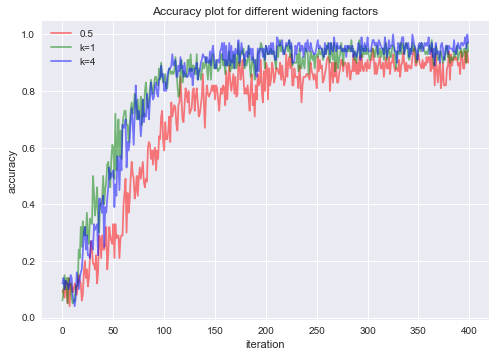

In [17]:
plt.title('Accuracy plot for different widening factors')
cols = ['r', 'g', 'b' ]
factors = ['0.5', 'k=1', \
              'k=4']

for i, current in enumerate(stats):
    plt.plot(current, c=cols[i], label = factors[i], alpha=0.5)

#     plt.plot(test_accs[i], c=cols[i], label = factors[i])

plt.legend()
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.show()

In [42]:
test_accs.keys()

dict_keys([0, 1, 2, 3, 4, 5])

In [34]:
j = 0
for i in test_accs.values():
    j += 1
    print(j)
    

1
2
3
4
5
6


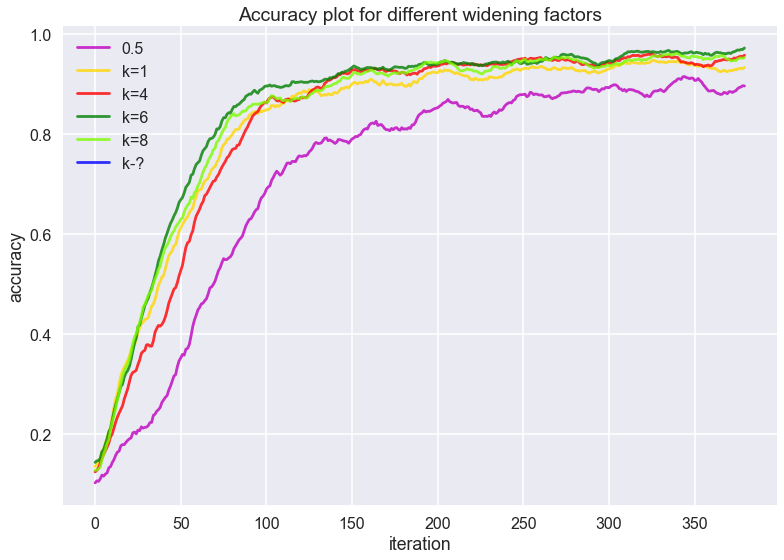

In [54]:
plt.style.use('seaborn-poster')
plt.title('Accuracy plot for different widening factors')
cols = ['m', 'gold', 'r', 'g', 'lawngreen', 'b' ]
factors = ['0.5', 'k=1', \
              'k=4', 'k=6', 'k=8', 'k-?']

for index, current in enumerate(test_accs.values()):
#     plt.plot(current, c=cols[i], label = factors[i], alpha=0.5)
    smoothed_current = []
    for i in range(10, len(current) - 10):
        smoothed_current.append(np.mean(current[i-10:i+10]))
    plt.plot(smoothed_current, c=cols[index], label = factors[index], alpha=0.8)

plt.legend()
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.show()

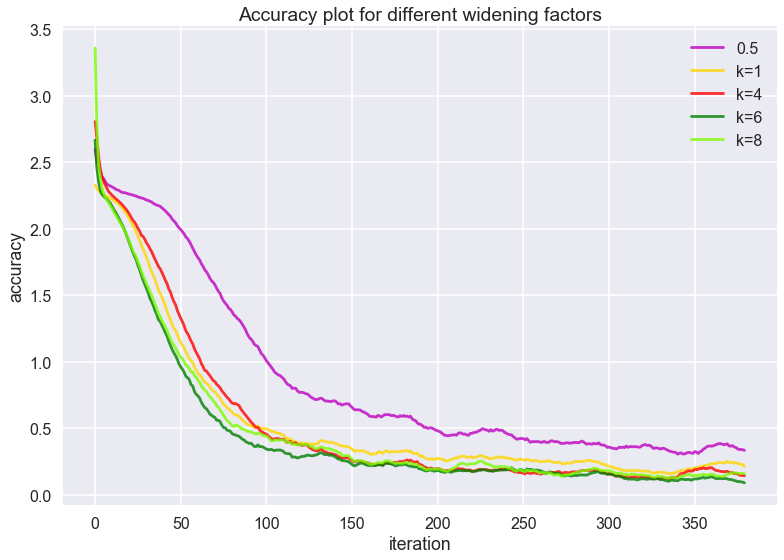

In [55]:
plt.style.use('seaborn-poster')
plt.title('Accuracy plot for different widening factors')
cols = ['m', 'gold', 'r', 'g', 'lawngreen', 'b' ]
factors = ['0.5', 'k=1', \
              'k=4', 'k=6', 'k=8', 'k-?']

for index, current in enumerate(test_losses.values()):
#     plt.plot(current, c=cols[i], label = factors[i], alpha=0.5)
    smoothed_current = []
    for i in range(10, len(current) - 10):
        smoothed_current.append(np.mean(current[i-10:i+10]))
    plt.plot(smoothed_current, c=cols[index], label = factors[index], alpha=0.8)

plt.legend()
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.show()

In [19]:
widening_factors = [6, 8]

In [20]:
f_stats = open('init_stats.txt', 'w')
f_loss = open('init_loss.txt', 'w')

for index, wid_factor in enumerate(widening_factors):
    config = {'resnet':{'conv_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                        'dense_initializer':tf.contrib.layers.variance_scaling_initializer(factor=2.0),\
                        'factor':wid_factor}}
    stats = []
    loss_history = []

    ppl = (train_dataset.pipeline(config=config).
       train_res(loss_history, stats, src[0][:58500], full_labs[:58500]))
    
    current_loss = []
    current_acc = []
    test_ppl = (test_dataset.p.import_model('resnet', ppl).update_stats(current_loss, current_acc, src[0][58500:], full_labs[58500:]))
        
#     ppl_test = test_dataset.pipeline(config=config)

    print('current config', config['resnet']['factor'])
    for i in tqdm(range(n_iterations)):
        ppl.next_batch(100, n_epochs=None, shuffle=2)
        test_ppl.next_batch(100, n_epochs=None, shuffle=2)

    test_losses[index+3] = current_loss
    test_accs[index+3] = current_acc
    
    pipelines.append(ppl)
    
    f_stats.write('\t'.join(map(str, stats)))
    f_stats.write('\n')
    
    f_loss.write('\t'.join(map(str, loss_history)))
    f_loss.write('\n')

current config 6


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

96 96
192 192
384 384


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [16:26<00:00,  2.39s/it]


current config 8


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

128 128
256 256
512 512


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [28:01<00:00,  4.12s/it]


In [64]:
all_layers = ppl.get_model_by_name('resnet')[-1][-1].graph.get_collection('trainable_variables')

In [80]:
all_layers

[<tf.Variable '11/kernel:0' shape=(7, 7, 1, 16) dtype=float32_ref>,
 <tf.Variable '11/bias:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable '0122/kernel:0' shape=(3, 3, 16, 128) dtype=float32_ref>,
 <tf.Variable '0122/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable '0222/kernel:0' shape=(3, 3, 128, 128) dtype=float32_ref>,
 <tf.Variable '0222/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'short22/kernel:0' shape=(1, 1, 16, 128) dtype=float32_ref>,
 <tf.Variable 'short22/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable '0133/kernel:0' shape=(3, 3, 128, 256) dtype=float32_ref>,
 <tf.Variable '0133/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable '0233/kernel:0' shape=(3, 3, 256, 256) dtype=float32_ref>,
 <tf.Variable '0233/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'short33/kernel:0' shape=(1, 1, 128, 256) dtype=float32_ref>,
 <tf.Variable 'short33/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable '0163/kernel:0' shape=(3, 3, 256, 512) dtype=f

In [82]:
def parameters_count(ppl):
    all_layers = ppl.get_model_by_name('resnet')[-1][-1].graph.get_collection('trainable_variables')
    n_parameters = 0
    for layer in all_layers:
        current_n = 1
        for dim_shape in (layer.get_shape().as_list()):
            current_n *= dim_shape
        n_parameters += current_n
    print (n_parameters)

4764074


In [85]:
for i in range(0):
    print('sd')